# Setup

In this notebook we create a model of bug prediction for each minor version of Hive.

In [3]:
# imports
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [4]:
# constants
INPUT_DIR = "../../data/input/"
OUTPUT_DIR = "../../data/output/"
FONT_SCALE = 1.3
RELEASED_MINOR_VERSIONS = ["2.0.0", "2.1.0", "2.2.0", "2.3.0", "3.0.0", "3.1.0"]

# configurations
sns.set(font_scale=FONT_SCALE)

# Load data

In [5]:
df = pd.read_csv(OUTPUT_DIR + "raw_dataset.csv")
df

,AvgCyclomatic,AvgEssential,AvgLine,CountDeclClass,CountDeclClassMethodRatio,CountDeclClassVariableRatio,CountDeclFunction,CountDeclInstanceMethodRatio,CountDeclMethod,CountDeclMethodDefaultRatio,...,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,Bug,Version
0,1.0,1.0,9.0,1.0,0.0,9.0,17.0,1.000000,17.0,0.176471,...,18.0,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0,2.0.0
1,2.0,1.0,8.0,2.0,0.0,0.0,21.0,1.000000,21.0,0.000000,...,8.5,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0,2.0.0
2,2.0,1.0,14.0,1.0,0.0,2.0,21.0,1.000000,21.0,0.000000,...,53.0,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0,2.0.0
3,2.0,1.0,29.0,1.0,0.0,17.0,8.0,1.000000,8.0,0.125000,...,26.0,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0,2.0.0
4,2.0,1.0,17.0,1.0,0.0,0.0,6.0,1.000000,6.0,0.000000,...,17.0,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0,2.0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75245,2.0,1.0,11.0,1.0,2.0,1.0,77.0,0.974026,77.0,0.000000,...,13.0,0.0,2.0,79.0,9.389610,3.389610,2.168831,2.0,0,3.1.3
75246,1.0,1.0,6.0,1.0,1.0,0.0,21.0,0.952381,21.0,0.000000,...,9.0,0.0,1.0,71.0,2.523810,2.666667,1.190476,1.0,0,3.1.3
75247,1.0,1.0,7.0,2.0,3.0,1.0,38.0,0.842105,38.0,0.078947,...,10.0,0.5,1.0,43.0,7.026316,2.421053,1.815789,2.0,0,3.1.3
75248,1.0,1.0,4.0,2.0,3.0,2.0,7.0,0.142857,7.0,0.000000,...,4.5,0.0,1.0,0.0,2.142857,2.000000,1.285714,2.0,0,3.1.3


### Clean data
Let's drop too correlated variables detected in [analysis.ipynb](analysis.ipynb)

In [6]:
df.drop(columns=['CountDeclClass', 'CountStmt', 'SumCyclomatic', 'SumEssential', 'CountDeclFunction', 'CountDeclMethod', 
              'CountDeclMethodDefaultRatio', 'CountLineCodeExeRatio', 'CountSemicolonRatio', 'CountStmtDeclRatio',
              'CountStmtExeRatio', 'CountLineCodeRatio', 'CountLineCommentRatio', 'AvgLine'], inplace=True)

Let's check the result using dissimilarity dendogram

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

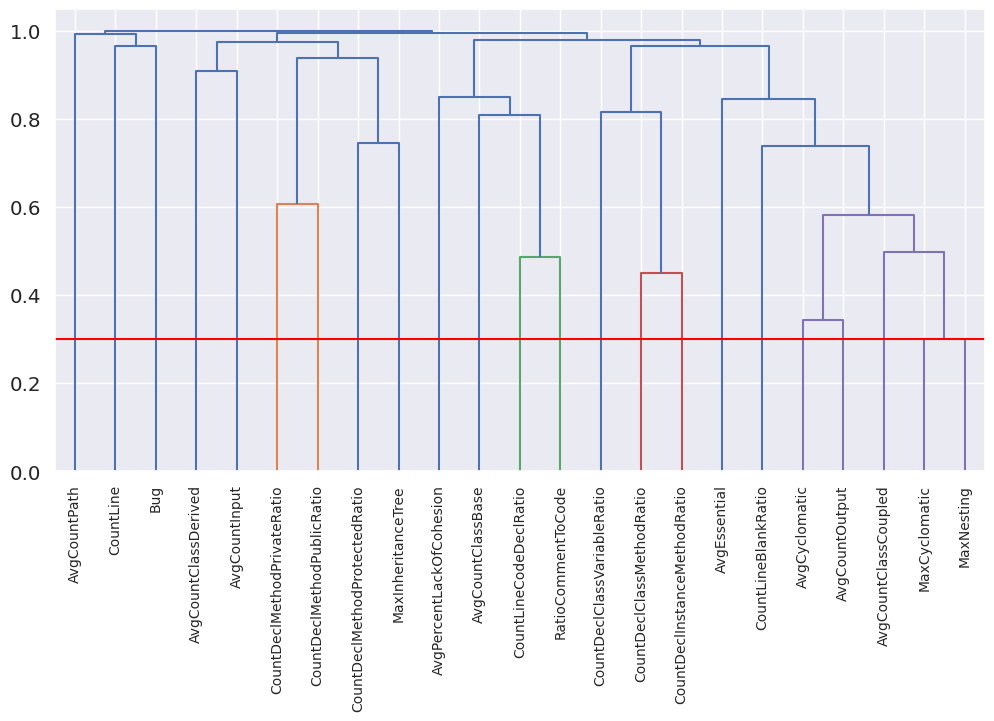

In [8]:
df_tmp = df.drop(columns=["Version"])
dissimilarity = 1 - abs(df_tmp.corr())
Z = linkage(squareform(dissimilarity), method="complete")

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_tmp.columns, orientation="top", leaf_rotation=90)
plt.axhline(y = .3, c="red")

# Models

In [9]:
# Utilities functions

"""Utilities functions."""


def results_headers(): 
  """Returns empty dataframe with correct headers."""
  return pd.DataFrame(columns=['Model', 'ROC-AUC', 'Precision', 'Recall', 'TT (sec)'])


def fit(model, name: str, append_to:pd.DataFrame=results_headers(), X_train=None, y_train=None, X_test=None, y_test=None, plot:bool=True):
  """Fit, evaluate model, and store the results.
  Plot confusion matrix and ROC Curve.
  
  Params
  ======
    model (Any): Sklearn model object.
    name (str): Model name for results.
    append_to (pd.DataFrame): Dataframe to which append the results.
    plot (bool): Plot cm and roc curve if True. Nothing if False.
  """
  # fit and predict model (with timer)
  start_time = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  timer = time.time() - start_time

  # get scores
  scores = get_scores(y_test, y_pred)

  if plot is True:
    # plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    print("\n")

    # ROC curve and score
    pos_probs = model.predict_proba(X_test)[:,1]
    plot_roc_curve(y_test, pos_probs, scores['ROC-AUC'], name)
    print("\n")

  # store results
  scores = get_scores(y_test, y_pred)
  scores['Model'] = name
  scores['TT (sec)'] = round(timer, 4)
  return append_to.append(scores, ignore_index=True)


def get_scores(y_test, y_pred):
  """Returns a single model scores."""
  return {
    'Model': 'undefined',
    'ROC-AUC': round(metrics.roc_auc_score(y_test, y_pred), 4),
    'Precision': round(metrics.precision_score(y_test, y_pred), 4),
    'Recall': round(metrics.recall_score(y_test, y_pred), 4),
    'TT (sec)': 'NaN'
  }

def plot_confusion_matrix(y_test, y_pred):
  cm = metrics.confusion_matrix(y_test, y_pred)
  # labels components
  titles_ = ['TN', 'FP', 'FN', 'TP']
  counts_ = ["{0:0.0f}".format(val) for val in cm.flatten()]
  pcts_ = ["{0:.0%}".format(val) for val in cm.flatten()/np.sum(cm)]
  # build labels
  labels = [f"{v1}\n{v2}  ({v3})" for v1, v2, v3 in zip(titles_, counts_, pcts_)]
  labels = np.asarray(labels).reshape(2, 2)
  # classes names
  categories = ['0', '1']
  # plot
  fig, ax = plt.subplots(figsize=(8, 6))
  fig.patch.set_facecolor('white')
  sns.set(font_scale=1.5)
  sns.heatmap(pd.DataFrame(cm), annot=labels, cmap="rocket", fmt='', xticklabels=categories, yticklabels=categories)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ax.xaxis.set_label_position("top")
  plt.show()
  sns.set(font_scale=FONT_SCALE)


def plot_roc_curve(y_test, pos_probs, roc_auc, title):
  fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_probs)
  # plot
  plt.figure(figsize=(8, 6))
  plt.subplot()
  plt.plot([0, 1], [0, 1], 'k--', label='No skill classifier')
  plt.plot(fpr, tpr, marker='.', label=title)
  plt.xlabel('FP Rate')
  plt.ylabel('TP Rate')
  plt.title(f'{title} - ROC curve')
  plt.annotate(f'AUC = {round(roc_auc, 5)}', xy=(0.7, 0.5), fontsize=12,)
  plt.legend()    
  plt.show()


def plot_feature_importances(model, name, lr=False):
  """Show model features importance."""
  feature_importances = pd.DataFrame(columns = ['features', 'weight'])
  feature_importances['features'] = X_train.columns
  feature_importances['weight'] = (
      model.coef_.reshape(len(feature_importances)) if lr else 
      model.feature_importances_
  )
  feature_importances = feature_importances.sort_values(['weight'], ascending=False)
  # plot
  fig = plt.figure(figsize=(6, 8))
  fig.patch.set_facecolor('white')
  sns.barplot(x='weight', y='features', data=feature_importances, palette="Spectral")
  plt.title(name + ' - Features importance', fontsize = 15)
  plt.show()


def save_model(model, filename):
  """Save a model as pickle."""
  joblib.dump(model, OUTPUT_DIR + f'/models/{filename}.pkl')


def load_model(filename):
  """Load model with name."""
  return joblib.load(OUTPUT_DIR + f'/models/{filename}.pkl')


def create_model():
    return make_pipeline(
        RandomUnderSampler(random_state=1, replacement=True),
        RandomForestClassifier(random_state=1, n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=False)
    )

In [30]:
results = results_headers()

In [31]:

# train models for each version and save it

for version in RELEASED_MINOR_VERSIONS:
    data = df[df["Version"] == version].drop(columns=["Version"])
    X_x = data.drop(columns=["Bug"])
    y = data["Bug"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X_x, y, test_size=.2, random_state=1)

    print(f"======================{version}=====================")

    model_ = create_model()
    results = fit(model_, f"{version}", results, X_train, y_train, X_test, y_test, False)
    save_model(model_, f"{version}")

======================2.0.0=====================


/tmp/ipykernel_3713/3950768621.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================2.1.0=====================


/tmp/ipykernel_3713/3950768621.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================2.2.0=====================


/tmp/ipykernel_3713/3950768621.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================2.3.0=====================


/tmp/ipykernel_3713/3950768621.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================3.0.0=====================


/tmp/ipykernel_3713/3950768621.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================3.1.0=====================


/tmp/ipykernel_3713/3950768621.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


In [32]:
results

,Model,ROC-AUC,Precision,Recall,TT (sec)
0,2.0.0,0.7865,0.0275,0.8571,0.7025
1,2.1.0,0.8650,0.2395,0.9091,1.2919
2,2.2.0,0.7630,0.1273,0.7241,0.8311
3,2.3.0,0.8872,0.0174,1.0000,0.6245
4,3.0.0,0.7931,0.0920,0.8000,0.7793
5,3.1.0,0.7396,0.0714,0.7619,0.9637


Let us plot performances evolution

### Metrics evolution

<AxesSubplot: xlabel='Model', ylabel='value'>

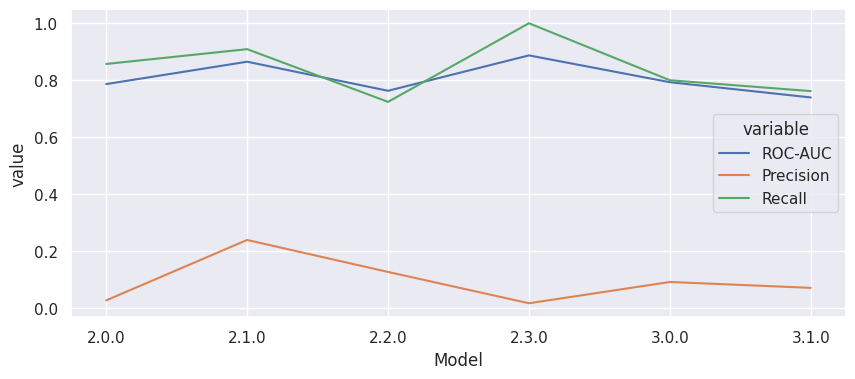

In [33]:
plt.figure(figsize=(10, 4))
sns.set(font_scale=1)

sns.lineplot(x='Model', y='value', hue='variable', 
             data=pd.melt(results.drop(columns=['TT (sec)']), ['Model']))

We can see that the model 2.3.0 has a perfect recall of 1 suggesting that there were more bugs in that version?